# Pauli Propagation Tutorial (Verified with Qiskit)

This notebook presents a concise tutorial on the core API of the Pauli propagation package for analyzing quantum circuits.

A 5-qubit quantum circuit is constructed, featuring four repetitions of two-qubit interactions. In each repetition, neighboring qubit pairs are randomly assigned $R_{XX}$, $R_{YY}$, or $R_{ZZ}$ gates.

The expectation value of the observable $Z_4 \otimes I_3 \otimes \ldots \otimes I_0$ is computed for the initial state $\ket{00000}$, using both the Pauli propagation method and the statevector approach for reference.

Finally, Monte Carlo sampling is applied to estimate the error in the expectation value across various truncation weights $k$.


In [1]:
# Standard library imports
import logging
import os


# Third-party imports
import matplotlib.pyplot as plt
import numpy as np


# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation.utils import encode_pauli

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
plt.rcParams['figure.dpi'] = 300

## Tutorial on propagator

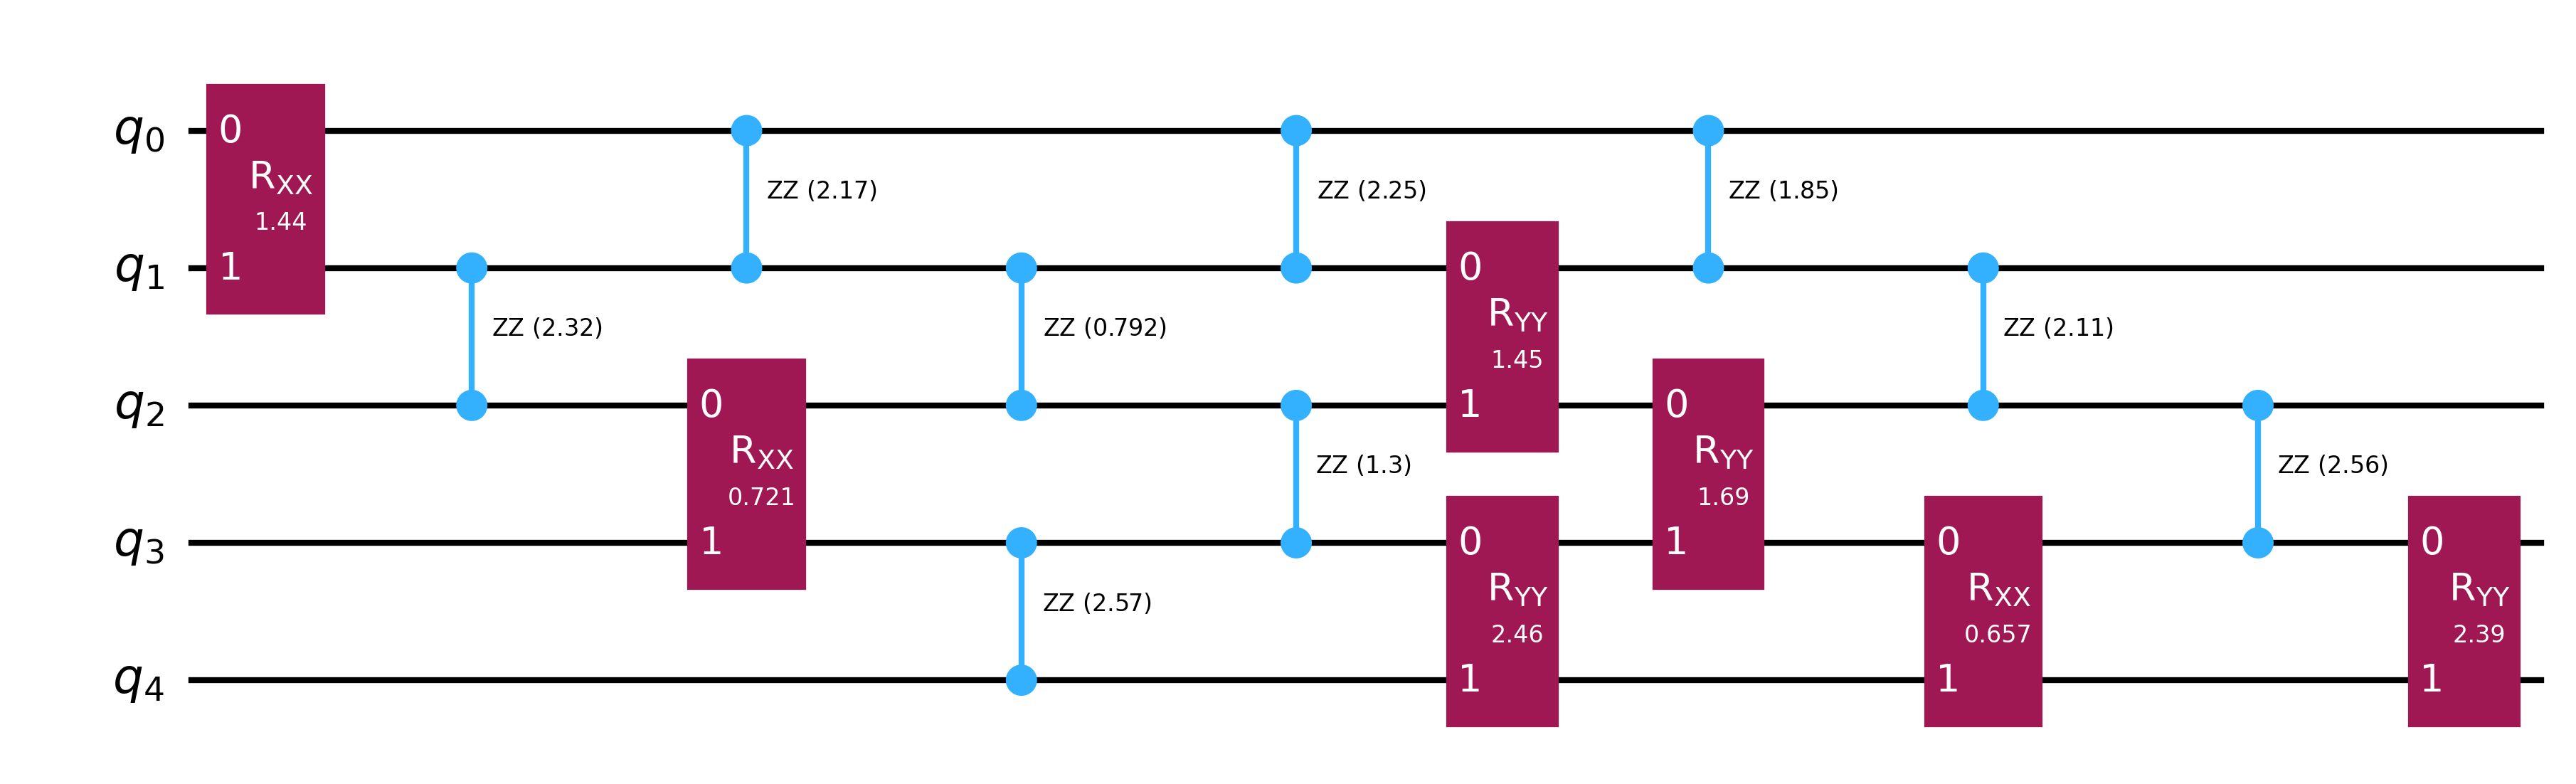

In [2]:
# Constructs a 5-qubit quantum circuit with 4 repetition of randomly chosen two-qubit RXX/RYY/RZZ gates
#  applied to neighboring qubit pairs

rng      = np.random.default_rng(seed=42)  # Set random seed

nq = 5
qc = QuantumCircuit(nq)

pairs = [(0, 1), (1, 2), (2, 3), (3, 4)]
for _ in range(4):
    for q1, q2 in pairs:
        gname  = rng.choice(["rxx", "ryy", "rzz"])
        theta  = rng.uniform(np.pi/6, 5*np.pi/6)
        getattr(qc, gname)(theta, q1, q2)   # call qc.rxx / ryy / rzz

qc.draw('mpl',fold = -1);

In [ ]:
# Calculate the exepectation of ZIII (Z on qubit 4) using Pauli Propagation
pauli_label1 = Pauli("Z" + "I" * (nq - 1))
init_key1  = encode_pauli(pauli_label1)
init_term1 = PauliTerm(1/np.sqrt(2), init_key1, nq)

pauli_label2 = Pauli("I" * (nq - 1) + "Z")
init_key2  = encode_pauli(pauli_label2)
init_term2 = PauliTerm(1/np.sqrt(2), init_key2, nq)

prop = PauliPropagator(qc)

product_label = "0" * nq # Initial state |00000> 

history_qc = prop.propagate([init_term1, init_term2] , max_weight=None)

expectation = prop.expectation_pauli_sum(history_qc[-1], product_label)
print(expectation)

Propagating, max weight: None:   0%|          | 0/16 [00:00<?, ?it/s]

0.6129006015634278


Below cell is equivalent to previous code cell, slight API difference for `prop.propagate`.


Previous code cell returns the full propagation history, below cell only return the final propagated result (which is faster)

In [4]:
# only contains the final propagated pauli sum
prop_result = prop.propagate([init_term1, init_term2], max_weight=None, history=False)

expectation = prop.expectation_pauli_sum(prop_result, product_label)
print(expectation)

Propagating, max weight: None:   0%|          | 0/16 [00:00<?, ?it/s]

0.6129006015634278


In [5]:
# Use qiskit's statevector method to evolve the same circuit

sv = Statevector.from_label(product_label) # |00000>
sv = sv.evolve(qc)

exp_sv = 1/np.sqrt(2) * sv.expectation_value(pauli_label1) + 1/np.sqrt(2) * sv.expectation_value(pauli_label2)
print("Statevector expectation:", exp_sv)

Statevector expectation: 0.612900601563428


## Tutorial on Monte Carlo

In [6]:

mc   = MonteCarlo(qc)

out_dir     = f"results/example"
os.makedirs(out_dir, exist_ok=True)
sample_file = os.path.join(out_dir, "mc_samples.pkl")

mc.monte_carlo_samples(init_term = init_term1, 
                       M = 100000,
                       sample_file = sample_file, 
                       load_existing = True)

mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator = prop, product_label =  "0" * nq,)

mse_dict = mse_mc_results_dict["MSE"]
var_dict = mse_mc_results_dict["Var"]

sqrt_var_dict = {k: np.sqrt(v) for k, v in var_dict.items()}
print("MSE estimate at difference truncation weight k")
print(f"{'k':<3} {'MSE':<10} {'sqrt(Var)':<12}")
for k in range(4):
    mse_val = mse_dict[k]
    sqrt_var_val = sqrt_var_dict[k]
    print(f"{k:<3} {mse_val:<10.5g} {sqrt_var_val:<12.5g}")

Loading existing samples from results/example\mc_samples.pkl...
Loaded 100000 existing samples
Already have 100000 samples, no new sampling needed
MSE estimate at difference truncation weight k
k   MSE        sqrt(Var)   
0   0.15351    0.00072932  
1   0.05198    0.00048258  
2   0.00613    0.000174    
3   0.00011    2.345e-05   
